<a href="https://colab.research.google.com/github/kridtapon/Mitigation-Block-Strategy/blob/main/Mitigation_Block_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00


In [ ]:
pip install --upgrade yfinance

In [ ]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.4 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
<ipython-input-40-e618468c6a8a>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-40-e618468c6a8a>:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-40-e618468c6a8a>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-40-e618468c6a8a>:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-40-e618468c6a8a>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

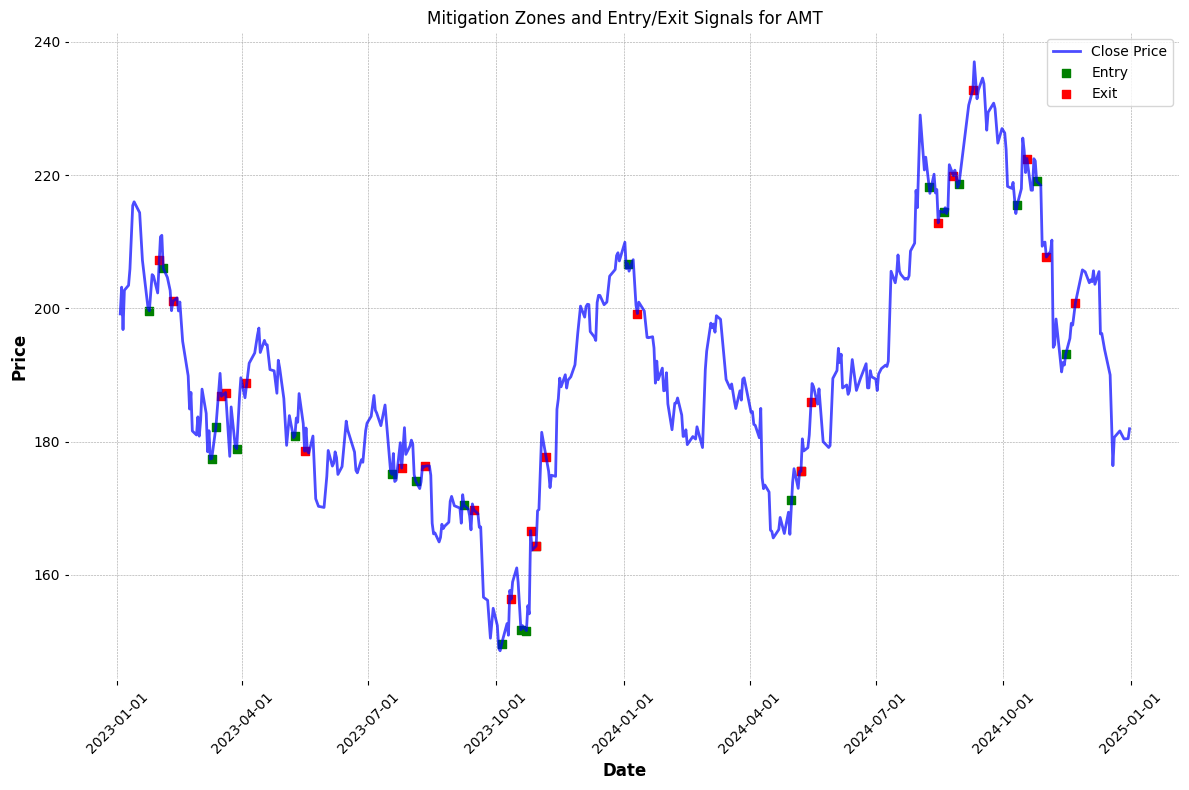

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Function to identify mitigation blocks (last opposing candle before big move)
def find_mitigation_blocks(df, lookback=30, threshold=2.0):
    mitigation_zones = []
    for i in range(lookback, len(df)):
        # If large bullish candle
        if df['Close'][i] > df['Open'][i] * threshold:
            last_bearish = df.iloc[i - lookback:i][df['Close'] < df['Open']]
            if not last_bearish.empty:
                zone_idx = last_bearish.index[-1]
                zone = (zone_idx, df.loc[zone_idx, 'Open'], df.loc[zone_idx, 'Close'])
                mitigation_zones.append(zone)
    return mitigation_zones

# Add mitigation block entry signals
def apply_mitigation_entry(df, mitigation_zones):
    entries = pd.Series(False, index=df.index)
    exits = pd.Series(False, index=df.index)

    for idx, open_price, close_price in mitigation_zones:
        zone_min = min(open_price, close_price)
        zone_max = max(open_price, close_price)
        # Check if price returns into mitigation zone within the next 15 candles
        for i in range(df.index.get_loc(idx)+1, min(df.index.get_loc(idx)+15, len(df))):
            candle_idx = df.index[i]
            # Check price is within mitigation zone
            if df.loc[candle_idx, 'Low'] <= zone_max and df.loc[candle_idx, 'High'] >= zone_min:
                # Rejection confirmation (pin bar or bearish engulfing approximation)
                body = abs(df['Close'][i] - df['Open'][i])
                wick = df['High'][i] - df['Low'][i]
                if body < wick * 0.5:
                    entries[candle_idx] = True
                    # Take profit at last swing high (TP1) - for demo, just 5 bars ahead
                    if i + 5 < len(df):
                        exits[df.index[i + 5]] = True
                    break
    return entries, exits

# Download data
symbol = 'AMT'
start_date = '2023-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Detect mitigation blocks
mitigation_blocks = find_mitigation_blocks(df, lookback=10, threshold=1.02)

# Apply Mitigation Entry Logic
df['Entry'], df['Exit'] = apply_mitigation_entry(df, mitigation_blocks)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.7)

# Plot Mitigation Zones (highlight the range of the mitigation block)
for zone_idx, open_price, close_price in mitigation_blocks:
    zone_min = min(open_price, close_price)
    zone_max = max(open_price, close_price)
    plt.axvspan(zone_idx, zone_idx, ymin=zone_min, ymax=zone_max, color='green', alpha=0.3)

# Plot Entry and Exit signals with box markers ('s' for square)
plt.scatter(df.index[df['Entry']], df['Close'][df['Entry']], marker='s', color='green', label='Entry', alpha=1)
plt.scatter(df.index[df['Exit']], df['Close'][df['Exit']], marker='s', color='red', label='Exit', alpha=1)

# Formatting the plot
plt.title(f'Mitigation Zones and Entry/Exit Signals for {symbol}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to identify mitigation blocks (last opposing candle before big move)
def find_mitigation_blocks(df, lookback=10, threshold=2.0):
    mitigation_zones = []
    for i in range(lookback, len(df)):
        # If large bullish candle
        if df['Close'][i] > df['Open'][i] * threshold:
            last_bearish = df.iloc[i - lookback:i][df['Close'] < df['Open']]
            if not last_bearish.empty:
                zone_idx = last_bearish.index[-1]
                zone = (zone_idx, df.loc[zone_idx, 'Open'], df.loc[zone_idx, 'Close'])
                mitigation_zones.append(zone)
    return mitigation_zones

# Add mitigation block entry signals
def apply_mitigation_entry(df, mitigation_zones):
    entries = pd.Series(False, index=df.index)
    exits = pd.Series(False, index=df.index)

    for idx, open_price, close_price in mitigation_zones:
        zone_min = min(open_price, close_price)
        zone_max = max(open_price, close_price)
        # Check if price returns into mitigation zone within the next 15 candles
        for i in range(df.index.get_loc(idx)+1, min(df.index.get_loc(idx)+15, len(df))):
            candle_idx = df.index[i]
            # Check price is within mitigation zone
            if df.loc[candle_idx, 'Low'] <= zone_max and df.loc[candle_idx, 'High'] >= zone_min:
                # Rejection confirmation (pin bar or bearish engulfing approximation)
                body = abs(df['Close'][i] - df['Open'][i])
                wick = df['High'][i] - df['Low'][i]
                if body < wick * 0.5:
                    entries[candle_idx] = True
                    # Take profit at last swing high (TP1) - for demo, just 5 bars ahead
                    if i + 5 < len(df):
                        exits[df.index[i + 5]] = True
                    break
    return entries, exits

# Download data
symbol = 'AMT'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Detect mitigation blocks
mitigation_blocks = find_mitigation_blocks(df, lookback=30, threshold=1.02)

# Apply Mitigation Entry Logic
df['Entry'], df['Exit'] = apply_mitigation_entry(df, mitigation_blocks)

# Filter test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Output
print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-39-ef7d3fd2e66f>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-39-ef7d3fd2e66f>:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-39-ef7d3fd2e66f>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-39-ef7d3fd2e66f>:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-39-ef7d3fd2e66f>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           161077.342712
Total Return [%]                        61.077343
Benchmark Return [%]                    -8.493532
Max Gross Exposure [%]                      100.0
Total Fees Paid                      10289.151619
Max Drawdown [%]                         20.55439
Max Drawdown Duration           579 days 00:00:00
Total Trades                                   43
Total Closed Trades                            43
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            55.813953
Best Trade [%]                          12.281195
Worst Trade [%]                         -8.792059
Avg Winning Trade [%]                    4.565587
Avg Losing Trade [%]                    -2.995042


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to identify mitigation blocks (last opposing candle before big move)
def find_mitigation_blocks(df, lookback=10, threshold=2.0):
    mitigation_zones = []
    for i in range(lookback, len(df)):
        if df['Close'][i] > df['Open'][i] * threshold:
            last_bearish = df.iloc[i - lookback:i][df['Close'] < df['Open']]
            if not last_bearish.empty:
                zone_idx = last_bearish.index[-1]
                zone = (zone_idx, df.loc[zone_idx, 'Open'], df.loc[zone_idx, 'Close'])
                mitigation_zones.append(zone)
    return mitigation_zones

# Add mitigation block entry signals
def apply_mitigation_entry(df, mitigation_zones):
    entries = pd.Series(False, index=df.index)
    exits = pd.Series(False, index=df.index)

    for idx, open_price, close_price in mitigation_zones:
        zone_min = min(open_price, close_price)
        zone_max = max(open_price, close_price)
        for i in range(df.index.get_loc(idx)+1, min(df.index.get_loc(idx)+15, len(df))):
            candle_idx = df.index[i]
            if df.loc[candle_idx, 'Low'] <= zone_max and df.loc[candle_idx, 'High'] >= zone_min:
                body = abs(df['Close'][i] - df['Open'][i])
                wick = df['High'][i] - df['Low'][i]
                if body < wick * 0.5:
                    entries[candle_idx] = True
                    if i + 5 < len(df):
                        exits[df.index[i + 5]] = True
                    break
    return entries, exits

# Download data
symbol = 'AMT'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate Moving Averages
df['SMA_Short'] = df['Close'].rolling(window=20).mean()
df['SMA_Long'] = df['Close'].rolling(window=50).mean()

# Detect crossovers
df['Bullish_Crossover'] = (df['SMA_Short'] > df['SMA_Long'])
df['Bearish_Crossover'] = (df['SMA_Short'] < df['SMA_Long'])

# Detect mitigation blocks
mitigation_blocks = find_mitigation_blocks(df, lookback=30, threshold=1.02)

# Apply Mitigation Entry Logic
entry_signals, exit_signals = apply_mitigation_entry(df, mitigation_blocks)

# Combine mitigation with MA crossover
df['Entry'] = entry_signals & df['Bullish_Crossover']
df['Exit'] = exit_signals | df['Bearish_Crossover']

# Filter test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Output
print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-36-780484f10676>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-36-780484f10676>:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-36-780484f10676>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-36-780484f10676>:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-36-780484f10676>:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

Start                               2020-01-02 00:00:00
End                                 2024-12-31 00:00:00
Period                               1258 days 00:00:00
Start Value                                    100000.0
End Value                                 112135.970969
Total Return [%]                              12.135971
Benchmark Return [%]                          -8.493532
Max Gross Exposure [%]                            100.0
Total Fees Paid                             4788.331053
Max Drawdown [%]                              16.915681
Max Drawdown Duration                 609 days 00:00:00
Total Trades                                         22
Total Closed Trades                                  22
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  40.909091
Best Trade [%]                                11.072989
Worst Trade [%]                               -4

[*********************100%***********************]  1 of 1 completed
<ipython-input-19-44f3b5663355>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-19-44f3b5663355>:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-19-44f3b5663355>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-19-44f3b5663355>:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-19-44f3b5663355>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

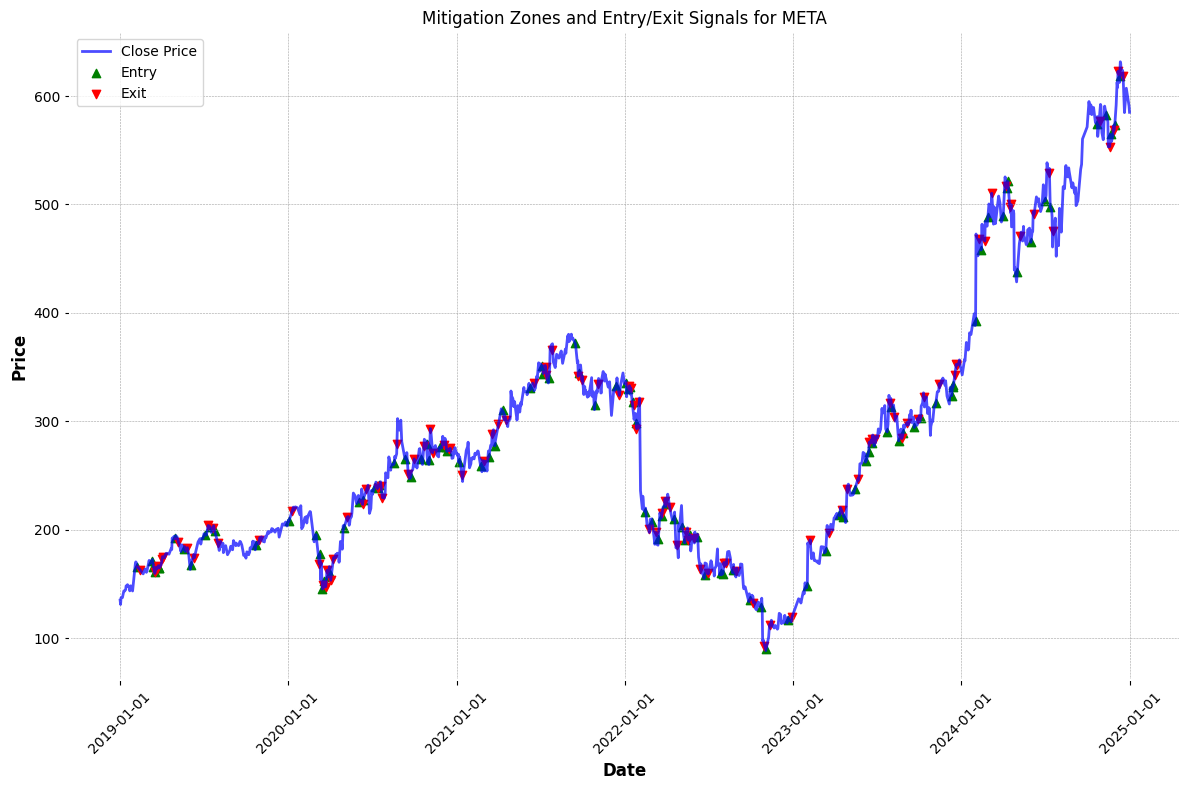

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Function to identify mitigation blocks (last opposing candle before big move)
def find_mitigation_blocks(df, lookback=10, threshold=2.0):
    mitigation_zones = []
    for i in range(lookback, len(df)):
        # If large bullish candle
        if df['Close'][i] > df['Open'][i] * threshold:
            last_bearish = df.iloc[i - lookback:i][df['Close'] < df['Open']]
            if not last_bearish.empty:
                zone_idx = last_bearish.index[-1]
                zone = (zone_idx, df.loc[zone_idx, 'Open'], df.loc[zone_idx, 'Close'])
                mitigation_zones.append(zone)
    return mitigation_zones

# Add mitigation block entry signals
def apply_mitigation_entry(df, mitigation_zones):
    entries = pd.Series(False, index=df.index)
    exits = pd.Series(False, index=df.index)

    for idx, open_price, close_price in mitigation_zones:
        zone_min = min(open_price, close_price)
        zone_max = max(open_price, close_price)
        # Check if price returns into mitigation zone within the next 15 candles
        for i in range(df.index.get_loc(idx)+1, min(df.index.get_loc(idx)+15, len(df))):
            candle_idx = df.index[i]
            # Check price is within mitigation zone
            if df.loc[candle_idx, 'Low'] <= zone_max and df.loc[candle_idx, 'High'] >= zone_min:
                # Rejection confirmation (pin bar or bearish engulfing approximation)
                body = abs(df['Close'][i] - df['Open'][i])
                wick = df['High'][i] - df['Low'][i]
                if body < wick * 0.5:
                    entries[candle_idx] = True
                    # Take profit at last swing high (TP1) - for demo, just 5 bars ahead
                    if i + 5 < len(df):
                        exits[df.index[i + 5]] = True
                    break
    return entries, exits

# Download data
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Detect mitigation blocks
mitigation_blocks = find_mitigation_blocks(df, lookback=10, threshold=1.02)

# Apply Mitigation Entry Logic
df['Entry'], df['Exit'] = apply_mitigation_entry(df, mitigation_blocks)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.7)

# Plot Mitigation Zones (highlight the range of the mitigation block)
for zone_idx, open_price, close_price in mitigation_blocks:
    zone_min = min(open_price, close_price)
    zone_max = max(open_price, close_price)
    plt.axvspan(zone_idx, zone_idx, ymin=zone_min, ymax=zone_max, color='green', alpha=0.3)

# Plot Entry and Exit signals
plt.scatter(df.index[df['Entry']], df['Close'][df['Entry']], marker='^', color='green', label='Entry', alpha=1)
plt.scatter(df.index[df['Exit']], df['Close'][df['Exit']], marker='v', color='red', label='Exit', alpha=1)

# Formatting the plot
plt.title(f'Mitigation Zones and Entry/Exit Signals for {symbol}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()
